In [1]:
# !pip install mlflow dagshub
import zipfile
import os
import itertools
import matplotlib.pylab as plt
import mlflow
import mlflow.keras
import dagshub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Navigate to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Human_Action_Recognition.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

dataset_path = '/content/dataset/'
print("Root contents:", os.listdir(dataset_path))

# Explore the structured folder
structured_path = '/content/dataset/Structured'
print("\nStructured folder contents:", os.listdir(structured_path))

# Check train and test folders
train_path = os.path.join(structured_path, 'train')
test_path = os.path.join(structured_path, 'test')

print(f"\nTrain folder contents: {os.listdir(train_path)}")
print(f"Test folder contents: {os.listdir(test_path)}")

Root contents: ['Structured']

Structured folder contents: ['test', 'train']

Train folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']
Test folder contents: ['running', 'clapping', 'calling', 'cycling', 'hugging', 'texting', 'using_laptop', 'sitting', 'eating', 'drinking', 'fighting', 'sleeping', 'dancing', 'laughing', 'listening_to_music']


In [4]:
def create_action_recognition_dataset(augment_training=True, validation_split=0.2):
    structured_path = '/content/dataset/Structured'
    train_path = os.path.join(structured_path, 'train')
    test_path = os.path.join(structured_path, 'test')

    CLASS_NAMES = sorted(os.listdir(train_path))

    # Full training dataset
    full_train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128,128),
        batch_size=16,
        shuffle=True,
        seed=42
    )

    # Split into train and validation
    dataset_size = len(full_train_dataset)
    train_size = int(dataset_size * (1 - validation_split))

    train_dataset = full_train_dataset.take(train_size)
    val_dataset = full_train_dataset.skip(train_size)

    # Test dataset
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(128,128),
        batch_size=16,
        shuffle=False
    )

    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    # Apply preprocessing
    train_dataset = train_dataset.map(preprocess)
    val_dataset = val_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    if augment_training:
        print("Augmenting training set")
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1),
            tf.keras.layers.RandomBrightness(0.1),
        ])

        def augment(image, label):
            image = data_augmentation(image, training=True)
            return image, label

        train_dataset = train_dataset.map(augment)

    # Optimize dataset performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, CLASS_NAMES

In [6]:
train_dataset, val_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

print(f"\nDataset created successfully!")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Classes: {CLASS_NAMES}")
print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Augmenting training set

Dataset created successfully!
Number of classes: 15
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train batches: 536
Validation batches: 134
Test batches: 119


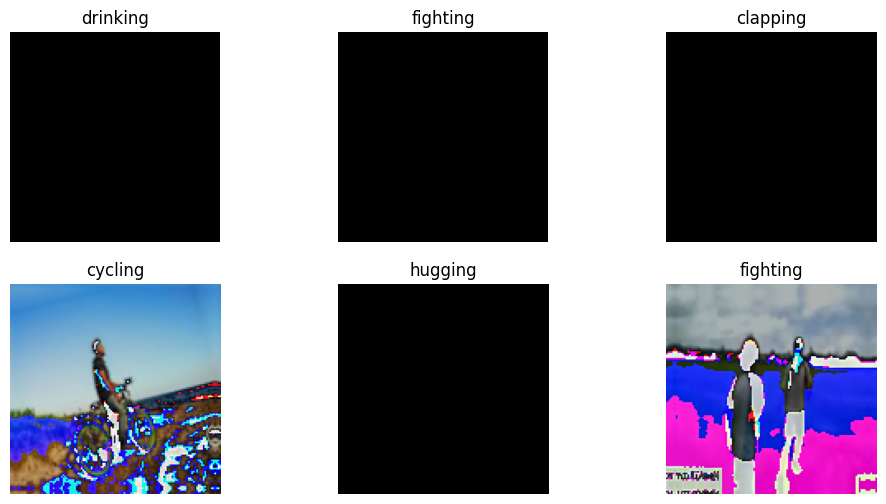

In [7]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        display_image = (images[i].numpy() * 255).astype("uint8")

        plt.imshow(display_image)
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')
    plt.show()

In [8]:
def plot_training(history):
    """Simple plot function"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [9]:
DAGSHUB_USERNAME = "Arej02"
DAGSHUB_REPO_NAME = "Human_Action_Recognition"

# Setup DagsHub connection
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME,mlflow=True)

# Set MLflow tracking to DagsHub
mlflow.set_tracking_uri(f"https://dagshub.com/Arej02/Human_Action_Recognition.mlflow")

Accessing as Arej02

Initialized MLflow to track repo "Arej02/Human_Action_Recognition"

Repository Arej02/Human_Action_Recognition initialized!

In [10]:
mlflow.set_experiment("Data Augmentation")

<Experiment: artifact_location='mlflow-artifacts:/15fcb8351978479c8728396826c9992d', creation_time=1764671504685, experiment_id='3', last_update_time=1764671504685, lifecycle_stage='active', name='Data Augmentation', tags={}>

In [11]:
def train_action_recognition():
    with mlflow.start_run(run_name="data_augmentation_v1"):

        train_dataset, val_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

        print(f"\nDataset Information:")
        print(f"Number of classes: {len(CLASS_NAMES)}")
        print(f"Training batches: {len(list(train_dataset))}")
        print(f"Validation batches: {len(list(val_dataset))}")
        print(f"Test batches: {len(list(test_dataset))}")

        base_model = VGG16(
            weights="imagenet",
            include_top=False,
            input_shape=(128, 128, 3)
        )
        base_model.trainable = False

        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.5),

            Dense(128),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.5),

            Dense(len(CLASS_NAMES), activation="softmax")
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.summary()

        print("\nStarting training...")
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=10,
            verbose=1
        )

        print("\n=== FINAL TEST EVALUATION ===")
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

        final_train_accuracy = history.history["accuracy"][-1]
        final_val_accuracy = history.history["val_accuracy"][-1]
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]

        # Log metrics
        mlflow.log_metric("Train Accuracy", final_train_accuracy)
        mlflow.log_metric("Validation Accuracy", final_val_accuracy)
        mlflow.log_metric("Test Accuracy", test_accuracy)
        mlflow.log_metric("Train Loss", final_train_loss)
        mlflow.log_metric("Validation Loss", final_val_loss)
        mlflow.log_metric("Test Loss", test_loss)

        # Log parameters
        mlflow.log_param("model", "VGG16 with augmentation")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", 16)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("augmentation", "True")

        plot_training(history)

        print(f"\n{'='*50}")
        print(f"FINAL RESULTS:")
        print(f"{'='*50}")
        print(f"Training Accuracy:    {final_train_accuracy:.4f}")
        print(f"Validation Accuracy:  {final_val_accuracy:.4f}")
        print(f"Test Accuracy:        {test_accuracy:.4f} ")
        print(f"{'='*50}")
        print(f"Training Loss:        {final_train_loss:.4f}")
        print(f"Validation Loss:      {final_val_loss:.4f}")
        print(f"Test Loss:            {test_loss:.4f}")
        print(f"{'='*50}")

        return test_loss, test_accuracy, final_val_accuracy

Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Augmenting training set

Dataset Information:
Number of classes: 15
Training batches: 536
Validation batches: 134
Test batches: 119


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,799,823 (56.46 MB)

 Trainable params: 84,623 (330.56 KB)

 Non-trainable params: 14,715,200 (56.13 MB)


Starting training...
Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.0766 - loss: 3.1753 - val_accuracy: 0.2029 - val_loss: 2.4422
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1033 - loss: 2.7540 - val_accuracy: 0.2451 - val_loss: 2.3247
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1189 - loss: 2.6398 - val_accuracy: 0.2793 - val_loss: 2.2547
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.1250 - loss: 2.5937 - val_accuracy: 0.2891 - val_loss: 2.1857
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1365 - loss: 2.5583 - val_accuracy: 0.3107 - val_loss: 2.1255
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.1545 - loss: 2.5121 - val_accuracy: 0.3093 - val_loss: 2.0765
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.1506 - loss: 2.5119 - val_accuracy: 0.3238 - val_loss: 2.0359
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.

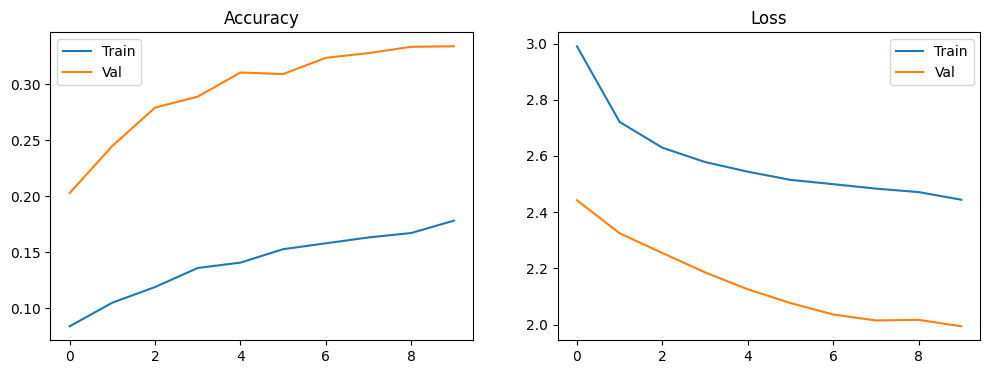


FINAL RESULTS:
Training Accuracy:    0.1783
Validation Accuracy:  0.3341
Test Accuracy:        0.3513  ← Most important!
Training Loss:        2.4442
Validation Loss:      1.9939
Test Loss:            1.9683
🏃 View run data_augmentation_v1 at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/3/runs/51fc1dc38b364a99bfb2fcd246c7fd4c
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/3


In [12]:
def main():
  test_loss, test_accuracy, final_val_accuracy = train_action_recognition()

if __name__ == "__main__":
    main()

In [13]:
mlflow.set_experiment("Data Augmentation (Fine-tuning)")

<Experiment: artifact_location='mlflow-artifacts:/b2490621e0de43b4aca96f151c3d5aa9', creation_time=1764672250298, experiment_id='4', last_update_time=1764672250298, lifecycle_stage='active', name='Data Augmentation (Fine-tuning)', tags={}>

In [14]:
def train_action_recognition():
  with mlflow.start_run(run_name="data_augmentation_v1"):
    train_dataset, val_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

    print(f"\nDataset Information:")
    print(f"Number of classes: {len(CLASS_NAMES)}")
    print(f"Training batches: {len(list(train_dataset))}")
    print(f"Validation batches: {len(list(val_dataset))}")
    print(f"Test batches: {len(list(test_dataset))}")

    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(128, 128, 3)
    )
    base_model.trainable = False

    model=Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(len(CLASS_NAMES),activation="softmax")
      ])

    model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    model.summary()

    print("\nStarting training...")
    history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=10,
            verbose=1
        )

    print("\n=== FINAL TEST EVALUATION ===")
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

    final_train_accuracy = history.history["accuracy"][-1]
    final_val_accuracy = history.history["val_accuracy"][-1]
    final_train_loss = history.history["loss"][-1]
    final_val_loss = history.history["val_loss"][-1]

    # Log metrics
    mlflow.log_metric("Train Accuracy", final_train_accuracy)
    mlflow.log_metric("Validation Accuracy", final_val_accuracy)
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Train Loss", final_train_loss)
    mlflow.log_metric("Validation Loss", final_val_loss)
    mlflow.log_metric("Test Loss", test_loss)

    # Log parameters
    mlflow.log_param("model", "VGG16 with augmentation")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 16)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("augmentation", "True")

    plot_training(history)

    print(f"\n{'='*50}")
    print(f"FINAL RESULTS:")
    print(f"{'='*50}")
    print(f"Training Accuracy:    {final_train_accuracy:.4f}")
    print(f"Validation Accuracy:  {final_val_accuracy:.4f}")
    print(f"Test Accuracy:        {test_accuracy:.4f}  ← Most important!")
    print(f"{'='*50}")
    print(f"Training Loss:        {final_train_loss:.4f}")
    print(f"Validation Loss:      {final_val_loss:.4f}")
    print(f"Test Loss:            {test_loss:.4f}")
    print(f"{'='*50}")

    return test_loss, test_accuracy, final_val_accuracy

Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Augmenting training set

Dataset Information:
Number of classes: 15
Training batches: 536
Validation batches: 134
Test batches: 119


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,799,823 (56.46 MB)

 Trainable params: 84,623 (330.56 KB)

 Non-trainable params: 14,715,200 (56.13 MB)


Starting training...
Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.0706 - loss: 3.1638 - val_accuracy: 0.1776 - val_loss: 2.4892
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1038 - loss: 2.7398 - val_accuracy: 0.2751 - val_loss: 2.3187
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.1244 - loss: 2.6434 - val_accuracy: 0.2779 - val_loss: 2.2544
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.1291 - loss: 2.5976 - val_accuracy: 0.2835 - val_loss: 2.1793
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.1432 - loss: 2.5560 - val_accuracy: 0.3018 - val_loss: 2.1406
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1512 - loss: 2.5131 - val_accuracy: 0.3182 - val_loss: 2.0930
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.1668 - loss: 2.4923 - val_accuracy: 0.3069 - val_loss: 2.0735
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.

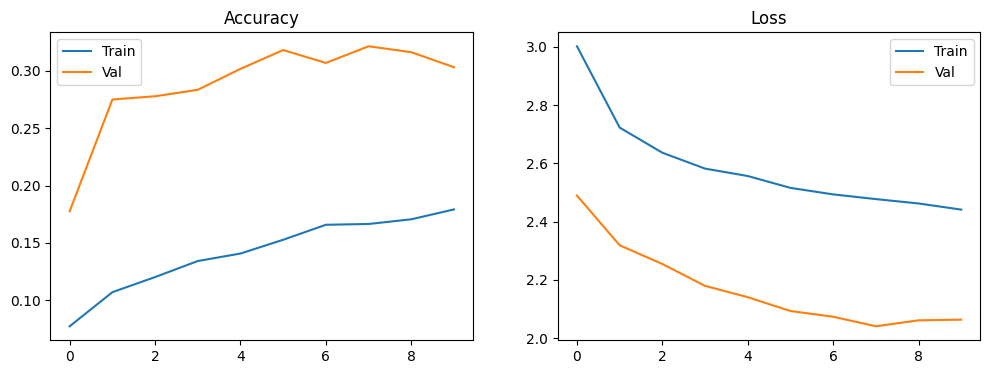


FINAL RESULTS:
Training Accuracy:    0.1792
Validation Accuracy:  0.3032
Test Accuracy:        0.3339  ← Most important!
Training Loss:        2.4410
Validation Loss:      2.0634
Test Loss:            2.0146
🏃 View run data_augmentation_v1 at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/4/runs/85039cfbe6974daba155f249dea5b077
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/4


In [15]:
def main():
  test_loss, test_accuracy, final_val_accuracy = train_action_recognition()

if __name__ == "__main__":
    main()